What is in scope:

Following something similar to bayesian cart to search over features. 

We will use linear svm accuracy over randomly generated data to determine whether our representation is an improvement or not

The goal of this topic is to determine the ideal projection when the dimensions of the input may vary (in columns). The dimensions of the columns are determined by feature generation/embeddings. 

Let:

*  $W$ be the projection matrix
*  $X$ to be the matrix representing input data which may vary in dimension from iteration to iteration
*  $Y$ be the result of the projection, i.e. $WX = Y$

WLOG fix the size of $Y$, (let's call this $d$). Then we have $W \in \mathbb{R}^{d \times n}$.

In this setting within the RJMCMC framework, the number of parameters we are estimating is:

*  all entries in $W$ ($d \times n$)  
*  all relevant combination of feature generation functions and their respective parameters 
                                             

### Examples of feature vector generation functions

As an example of an algorithm which we should compare is the multivariate adaptive regression splines (MARS)

**Hinge Function**

The hinge function ($f_\text{hinge}$) is similiar to ReLu), can be defined as a feature generation function, (_probably not the right way to write this out_)

$$ f_{\text{hinge}^+} (X_{j}, \theta) = (X_j-\theta \mathbf{1})_{+}$$

Where $X_j$ represents the $j$th column, without loss of generality we can likewise define $f_{\text{hinge}^-} (X_{j}, \theta) = (\theta \mathbf{1} - X_j)_{+}$

**Interaction**

Interaction term will be defined the dot product of two feature vectors (which can be the same feature vector), (_probably not the right way to write this out_)

$$ f_\text{interaction} (X_1, X_2) = X_1  \cdot X_2 $$

Replicating MARS in RJMCMC
--------------------------

[MARS](https://en.wikipedia.org/wiki/Multivariate_adaptive_regression_splines) is a prime candidate for exploring this problem. 

In the RJMCMC space we have the following decisions:

1. GROW - we can grow the state by Proposing a new feature vector generation transformation and respective parameter, e.g. hinge, interaction, or more complex function transforms which could be a composition of function generation...
2. DESTROY - we can also delete a created feature

This would be represent moving from one state to another.                                  

In [1]:
import numpy as np
import pandas as pd

from hinge import Hinge, error_on_split
from interaction import Interaction

from sklearn import datasets
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn import preprocessing

# using svm as per scikit-feature repo
from sklearn.decomposition import FactorAnalysis # we shall use factor analysis to fix the size of final modelling ds.
from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# for sampling
import random # use random.choice? and random.sample for interactions

# use networkx to keep track of changes to our data, so we can recreate things...
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import make_classification

problem_setup = {
    'n_samples': 300, 
    'n_features': 50, 
    'n_informative': 10, 
    'n_redundant': 10, 
    'n_classes': 3, 
    'random_state': 0    
}

X, y = make_classification(**problem_setup)
X = X.astype(float)
n_samples, n_features = X.shape    # number of samples and number of features



In [3]:
import pandas as pd # for making sure and exploring created datasets...
X_df = pd.DataFrame(X)
base_names = ["base_{}".format(x) for x in range(n_features)]
X_df.columns = base_names[:]
X_df.head()

,base_0,base_1,base_2,base_3,base_4,base_5,base_6,base_7,base_8,base_9,...,base_40,base_41,base_42,base_43,base_44,base_45,base_46,base_47,base_48,base_49
0,0.140673,-1.056507,0.211336,-0.051245,-1.707436,0.812612,0.529927,0.337739,-0.010239,5.082635,...,-2.159166,-0.505031,-0.290300,-1.423013,-3.531133,-0.074873,-2.908971,-0.533449,0.512048,-1.315979
1,1.734870,1.749369,0.393464,0.148533,-1.712113,-0.199287,-0.667767,-0.943495,0.681635,10.447742,...,-0.558268,-7.479695,-1.706696,-1.395395,0.973802,-1.041347,-6.201191,-1.176442,0.944423,0.898251
2,-5.493219,-2.420378,1.699525,0.362889,2.864180,-0.716517,0.473016,-2.715607,-1.177175,1.574229,...,-1.303525,1.311686,-0.583548,-0.007803,-0.151316,-0.385398,-3.257219,1.409357,-2.276589,-0.894274
3,2.791666,-0.639234,-0.763891,1.370567,-5.788661,-0.260745,1.800210,-1.234377,-1.453207,-1.568038,...,2.405260,-1.256116,-0.726343,-0.655469,4.565850,-0.863371,0.646507,1.113179,3.217174,-1.646719
4,3.785220,-0.750653,1.519439,-0.643260,-11.617471,0.649915,-2.345340,2.838290,-0.866542,-0.351528,...,1.227032,-0.983323,-1.639763,0.144169,0.267208,1.068478,-4.026710,-2.084032,4.185424,-0.085756


In [4]:
def eval_pipeline(additional_feats=[], X=X_df, y=y, verbose=True):
    pipeline = additional_feats[:]
    pipeline.append(('factor analysis', FactorAnalysis(20)))
    pipeline.append(('linear svm', LinearSVC()))
    model = Pipeline(pipeline[:])

    # split data into 10 folds
    kfold = KFold(n_splits=3, shuffle=True)
    results = cross_val_score(model, X, y, cv=kfold)
    if verbose:
        print("Accuracy: {}".format(results.mean()))
    return results.mean()

In [5]:
# baseline solution - vanilla pipeline
eval_pipeline(X=X_df)

Accuracy: 0.7366666666666667


0.73666666666666669

Feature Search
=======

We have 4 possible situations:

1. Grow - split : assumption is we always grow 2
2. Grow - interaction
3. Remove - split : assumption is we always destroy both
4. Remove - interaction

Proposal Distributions
------------------------

Assume each action has equal probability and is uniform

### Splits

**Grow (Split) | Base (Remove) **

We will use the same probability of split as given in Bayesian cart: $p_{\text{split}}(X_i) = \alpha(1+\text{total_splits})^{-\beta}$
where $\text{total_splits}$ represents the total number of times a node has been created for column $X_i$. Then

$$P(\text{ Grow (Split) } | \text{ Base (Remove }) = \frac{1}{4} \alpha(1+\text{total_splits})^{-\beta} $$ 

----

For now we will make it simple, and say if it is chosen it will always split.

This would be...

$$P(\text{ Grow (Split) } | \text{ Base (Remove }) = \frac{1}{4} \frac{1}{\text{candidate children nodes}} $$ 

**Base (Remove) | Grow (Split)**

This should be the same as drawing based on number of additional features created (call this $n$). 

$$P(\text{ Base (Remove) } | \text{ Grow (Split) }) = (\frac{1}{4}  \frac{2}{n}) \times (\frac{1}{4}  \frac{1}{n-1}) = \frac{1}{8}  \frac{1}{n(n-1)}$$

----


For now we will make it simple, and say if it is chosen it will always split.

This would be...

$$P(\text{ Grow (Split) } | \text{ Base (Remove }) = \frac{1}{4} \frac{1}{\text{candidate parent nodes}} $$ 

Note that the parent nodes chosen here can only be one level up from the terminal node....

### Interaction

**Grow (Interaction) | Base (Interaction)**

This again is your binomial draws, this one is based on total number of features, which we will denote by $d + n$, i.e. original size of your dataset and the total number of generated features. 

$$P(\text{ Grow (Interaction) } | \text{ Base (Interaction) }) = \frac{1}{4} \frac{2}{(d+n)(d+n-1)} = \frac{1}{2} \frac{1}{(d+n)(d+n-1)}$$

Note that anything can have interaction! So we can't presume as above.

**Base (Interaction) | Grow (Interaction)**

This is just choosing one particular feature that is created.

$$P(\text{ Base (Interaction) } | \text{ Grow (Interaction) }) = \frac{1}{4} \frac{1}{\text{candidate interaction parents}}$$


In [6]:
# our proposal distributions

def split_given_remove(num_splits):
    # make this simplier for now...
    #return 0.25 * alpha * ((1.0+num_splits)^(-beta))
    return 0.25 * 
    

def remove_given_split(num_created):
    # num created is the number of base spllits, we can possibly 
    # remove!
    return 0.125 * (1.0/(num_created*(num_created-1)))

def interact_given_remove(base_dim, num_created):
    from scipy.misc import comb
    total_dim = base_dim + num_created
    return 0.5 * (1.0/(total_dim * (total_dim - 1)))

def remove_given_interact(num_created):
    return 1/(4.0*num_created) 

In [7]:
"""
each model proposal can be represented by a dictionary
so the markov chain will be a list of dictionaries

Sample usage:

ds_pipeline = [
    ('hinge', Hinge()), 
    ('interaction', Interaction([1,2]))
    ]

eval_pipeline(ds_pipeline)
"""

def get_name(name):    
    clean_name = name.split("_")
    return clean_name


def spawn_split(X=X_df):
    """Assuming split is chosen, generate a new split"""
    # choose a random column
    # grab things like this...X_df.iloc[:, 3].name
    chosen_col = random.choice(range(X.shape[1]))
    return chosen_col

def spawn_interact(X=X_df):
    """assuming interaction was chosen, generate a new interaction between two columns"""
    chosen_columns = random.sample(range(X.shape[1]), 2)
    return chosen_columns

In [8]:
def graph_to_dict(G):
    return dict(nodes=[[n, G.node[n]] for n in G.nodes()],
                   edges=[[u, v, G.edge[u][v]] for u,v in G.edges()])

def dict_to_graph(dict_obj):
    G = nx.DiGraph()
    G.add_nodes_from(dict_obj['nodes'])
    G.add_edges_from(dict_obj['edges'])
    return G

def print_graph_from_dict(dict_obj):
    G = dict_to_graph(dict_obj)
    nx.draw_random(G)
    

In [19]:
# generate the base graph, where we have a the root node and all the base features...
G=nx.DiGraph()
G.add_node("root")

for col in base_names:
    # we can add node attributes, eg
    #G.add_node(col, attribute='here')
    G.add_node(col)
    G.add_edge("root", col)

simulations = []
simulations.append(graph_to_dict(G))

c:\users\chapm\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
c:\users\chapm\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
c:\users\chapm\anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
c:\users\chapm\anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in

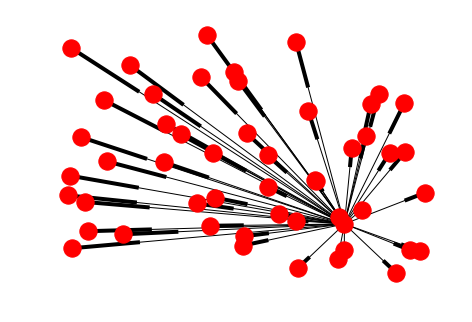

In [20]:
print_graph_from_dict(simulations[0])

In [ ]:
def get_all_hinge_candidates():
    pass

def get_all_interaction_candidates():
    pass



In [12]:
# from 
def dict_to_pipeline(dict_obj):
    """
    converts a dictionary to a pipeline object.
    
    
    parameters:
    d is a dictionary    
    
    return:
    pipeline object, which is a list of tuples
    
    we can add attributes to nodes - how will this be reflected?
    """
    pipeline = []
    G = dict_to_graph(dict_obj)
    
    for parent, child in G.edges():
        if parent == 'root': 
            continue
        
        # now process everything else...
        if "hinge" in child:
            # do something assume, we have neg, pos 
            proposed_pipeline = []
        
        if "interact" in child:
            # find the two parents...
            pass
            
        
    
    return []
    




SyntaxError: invalid syntax (<ipython-input-12-2f30243bdc02>, line 23)